# Convolutional Neural Networks: Application

In this notebook, we will:

- Implement helper functions that we use when implementing a TensorFlow model and 
- Implement a fully functioning ConvNet using TensorFlow 

The implementation is inspired from Course 4 in Deep Learning Speacialization by Andrew Ng in Coursera.

The dataset we use is the signs dataset present in the datasets folder of this repository. The SIGNS dataset is a collection of 6 signs representing numbers from 0 to 5.


## TensorFlow model

Most practical applications of deep learning today are built using programming frameworks, which have many built-in functions that we can simply call. We will ones such framework called "TensorFlow"
 

In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf
from tensorflow.python.framework import ops
%matplotlib inline
np.random.seed(123)

In [2]:
# Loading the dataset (signs)
def load_dataset():
    train_dataset = h5py.File('train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) #  train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) #  train set labels

    test_dataset = h5py.File('test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) #  test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) #  test set labels

    classes = np.array(test_dataset["list_classes"][:]) #  list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 0


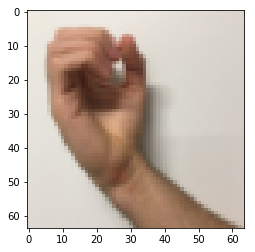

In [3]:
# Example of a picture in the data set
index = 18
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [4]:
#Examining shapes of data set and Standardizing

X_train = X_train_orig/255.
X_test = X_test_orig/255.

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


###  Create placeholders

TensorFlow requires that we create placeholders for the input data that will be fed into the model when running the session.
We implement the function below to create placeholders for the input image X and the output Y.
    We do not define the number of training examples for the moment by using "None" as the batch size, as it will give us the flexibility to choose it later. Hence X willbe of dimension **[None, n_H0, n_W0, n_C0]** and Y of dimension **[None, n_y]**.

In [5]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    X = tf.placeholder(tf.float32,[None,n_H0,n_W0,n_C0])
    Y = tf.placeholder(tf.float32,[None,n_y])
    
    return X, Y

### Parameter Initialization

We will initialize weights/filters $W1$ and $W2$ using `tf.contrib.layers.xavier_initializer(seed = 0)`. We don't need to worry about bias variables as the TensorFlow functions takes care of the bias. Also note that we will only initialize the weights/filters for the conv2d functions. TensorFlow initializes the layers for the fully connected part automatically. 

[More Info](https://www.tensorflow.org/api_docs/python/tf/get_variable).

In [6]:
def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 3, 8]
                        W2 : [2, 2, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.set_random_seed(123)                             
    
    W1 = tf.get_variable("W1",[4,4,3,8],initializer= tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2",[2,2,8,16],initializer=tf.contrib.layers.xavier_initializer(seed = 0))
   

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

###  Forward propagation

In TensorFlow, there are built-in functions that carry out the convolution steps f.

- **tf.nn.conv2d(X,W1, strides = [1,s,s,1], padding = 'SAME'):** given an input $X$ and a group of filters $W1$, this function convolves $W1$'s filters on X. The third input ([1,f,f,1]) represents the strides for each dimension of the input (m, n_H_prev, n_W_prev, n_C_prev). You can read the full documentation [here](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d)

- **tf.nn.max_pool(A, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME'):** given an input A, this function uses a window of size (f, f) and strides of size (s, s) to carry out max pooling over each window. You can read the full documentation [here](https://www.tensorflow.org/api_docs/python/tf/nn/max_pool)

- **tf.nn.relu(Z1):** computes the elementwise ReLU of Z1 (which can be any shape). You can read the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/nn/relu)

- **tf.contrib.layers.flatten(P)**: given an input P, this function flattens each example into a 1D vector it while maintaining the batch-size. It returns a flattened tensor with shape [batch_size, k]. You can read the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/flatten)

- **tf.contrib.layers.fully_connected(F, num_outputs):** given a the flattened input F, it returns the output computed using a fully connected layer. You can read the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/fully_connected)

In the last function above (`tf.contrib.layers.fully_connected`), the fully connected layer automatically initializes weights in the graph and keeps on training them as we train the model. Hence, we do not need to initialize those weights when initializing the parameters. 

`forward_propagation` function below builds the following model: `CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED`. 

We will use the following parameters for all the steps:
     - Conv2D: stride 1, padding is "SAME"
     - ReLU
     - Max pool:  8 by 8 filter size and  8 by 8 stride, padding is "SAME"
     - Conv2D: stride 1, padding is "SAME"
     - ReLU
     - Max pool: 4 by 4 filter size and a 4 by 4 stride, padding is "SAME"
     - Flatten the previous output.
     - FULLYCONNECTED (FC) layer

In [7]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing  parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieving the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
  
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding="SAME")
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1,W2,strides=[1,1,1,1],padding="SAME")
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function 
    # 6 neurons in output layer. 
    Z3 = tf.contrib.layers.fully_connected(P2, num_outputs=6,activation_fn=None)
   

    return Z3

### Cost

We compute cost with the help of the below functions:

- **tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y):** computes the softmax entropy loss. This function both computes the softmax activation function as well as the resulting loss. You can check the full documentation  [here.](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits)
- **tf.reduce_mean:** computes the mean of elements across dimensions of a tensor. We use this to sum the losses over all the examples to get the overall cost. You can check the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/reduce_mean)


In [8]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
  
    
    return cost

#### Random mini batches

In [9]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
   
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

## Building Model 

We will merge the helper functions that we implemented above to build a model and train it on the SIGNS dataset. 

The model below will:

- create placeholders
- initialize parameters
- forward propagate
- compute the cost
- create an optimizer

Finally we will create a session and run a for loop for num_epochs, get the mini-batches, and then for each mini-batch we will optimize the function. [More Info](https://www.tensorflow.org/api_docs/python/tf/global_variables_initializer)

In [10]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. 
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(123)                             
    seed = 123                                         
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Creating Placeholders 
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    

    # Initializing parameters
    parameters =initialize_parameters()
       
    # Forward propagation
    Z3 = forward_propagation(X,parameters)
        
    # Cost function: A
    cost = compute_cost(Z3,Y)
   
    
    # Backpropagation using an AdamOptimizer that minimizes the cost.
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
   
    
    # Initializing all the variables globally
    init = tf.global_variables_initializer()
     
    # Starting the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Running the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
         
                _ , temp_cost =sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                                
                minibatch_cost += temp_cost / num_minibatches
                

            # Printing the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plotting the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculating the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculating accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 1.921366
Cost after epoch 5: 1.902416
Cost after epoch 10: 1.669835
Cost after epoch 15: 1.359895
Cost after epoch 20: 1.219370
Cost after epoch 25: 1.156031
Cost after epoch 30: 1.052211
Cost after epoch 35: 1.074118
Cost after epoch 40: 1.085886
Cost after epoch 45: 0.975411
Cost after epoch 50: 0.941525
Cost after epoch 55: 0.921955
Cost after epoch 60: 0.884798
Cost after epoch 65: 0.878379
Cost after epoch 70: 0.877265
Cost after epoch 75: 0.824797
Cost after epoch 80: 0.826706
Cost after epoch 85: 0.764100
Cost after epoch 90: 0.745607
Cost after epoch 95: 0.760287


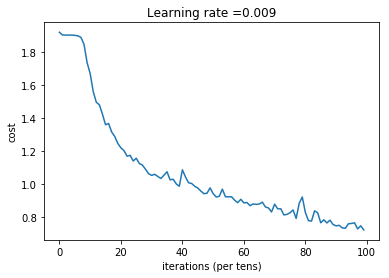

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.775
Test Accuracy: 0.725


In [11]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

We have now built a model that recognizes SIGN language with almost 76% accuracy on the test set. We can further improve its accuracy by spending more time tuning the hyperparameters, or using regularization (as this model clearly has a high variance). 
